In [1]:
import os

import itk
from itk import TubeTK as tube

from itkwidgets import view

import numpy as np

In [2]:
BaseName = "Rat19N_w3"
#Rat17_w2
#Rat44L_w2
#Rat47R_w2

InputDir = "../Data"
InputBaseName = os.path.join(InputDir, BaseName)

OutputDir = '../Data/Results-' + BaseName
if not os.path.exists(OutputDir):
    os.makedirs(OutputDir)
OutputBaseName = os.path.join(OutputDir, BaseName + "-out")

InputFilename = InputBaseName+".nrrd"

im = itk.imread(InputFilename, itk.F)

In [3]:
imMath = tube.ImageMath.New(im)
imMath.Blur(1.5)
imBlur = imMath.GetOutput()


spacing = imBlur.GetSpacing()[0]

imArray = itk.GetArrayFromImage(imBlur)
im_mean = np.mean(imArray)
im_stddev = np.std(imArray)

print("Spacing:", spacing)
print("Intensity mean:", im_mean)
print("Intensity std dev:", im_stddev)

Spacing: 1.0
Intensity mean: 0.003970461
Intensity std dev: 0.07533953


In [4]:
imArrayNorm = (imArray - im_mean)/(im_stddev*10)
imArrayNorm = np.where(imArrayNorm>1, 1.0, imArrayNorm)
imArrayNorm = np.where(imArrayNorm<-1, -1.0, imArrayNorm)
im_min = imArrayNorm.min()
im_max = imArrayNorm.max()
imArrayNorm = (imArrayNorm - im_min) / (im_max - im_min) * 100
imNorm = itk.GetImageFromArray(imArrayNorm)

In [5]:
itk.imwrite(imNorm, OutputBaseName+"-Normalized.mha")


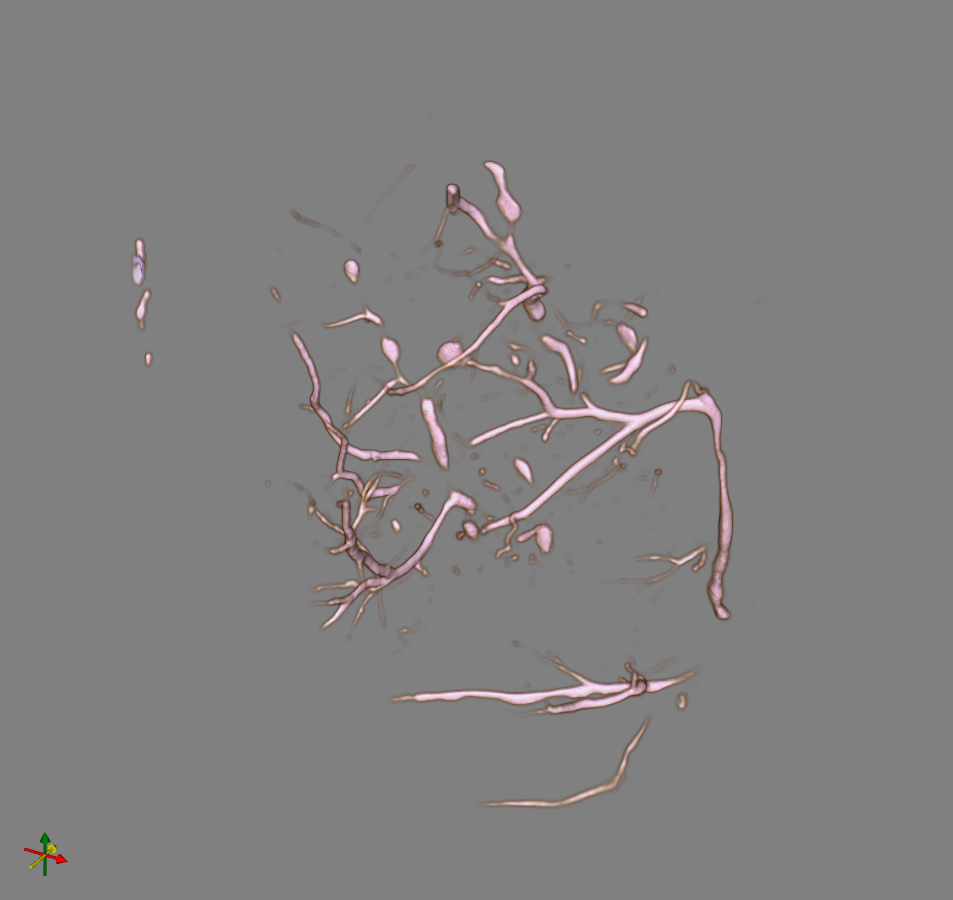
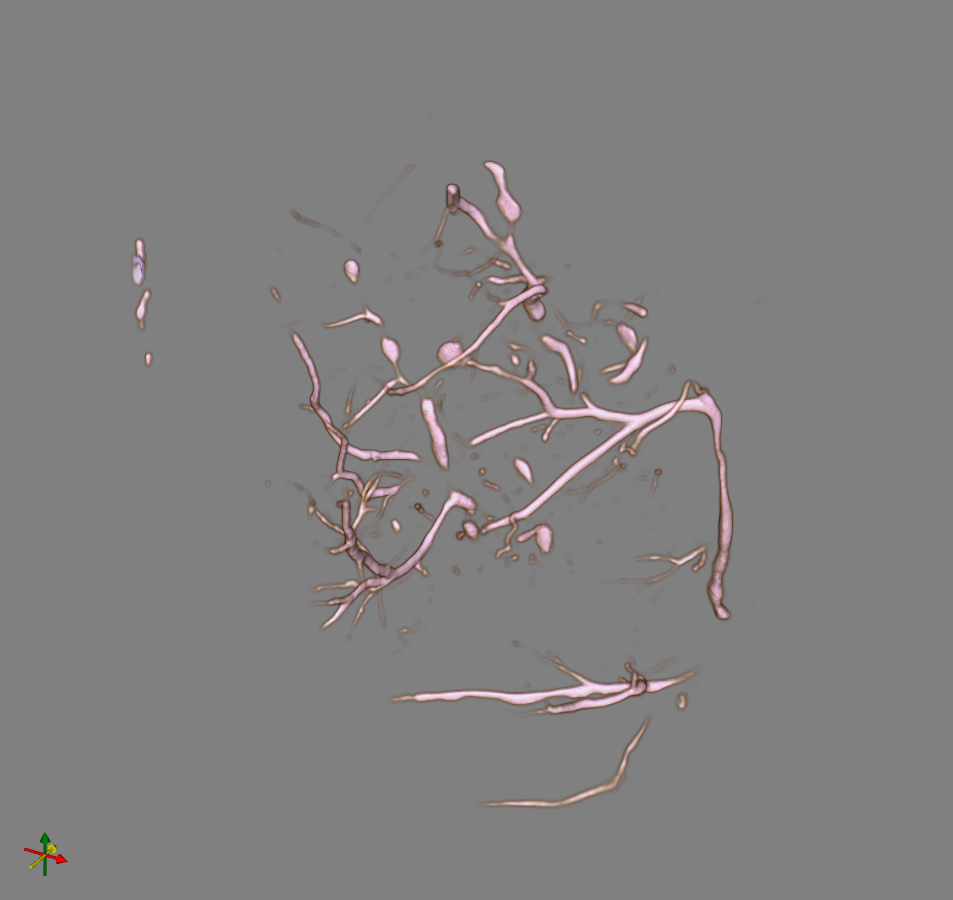

<IPython.core.display.Javascript object>

In [6]:
view(imNorm)

In [7]:
numSeeds = 25
seedCoverage = 20
seedCoord = np.zeros([numSeeds,3])
for i in range(numSeeds):
    seedCoord[i] = np.unravel_index(np.argmax(imArrayNorm, axis=None), imArrayNorm.shape)
    indx = [int(seedCoord[i][0]),int(seedCoord[i][1]),int(seedCoord[i][2])]
    minX = max(indx[0]-seedCoverage,0)
    maxX = min(indx[0]+seedCoverage,imArrayNorm.shape[0])
    minY = max(indx[1]-seedCoverage,0)
    maxY = min(indx[1]+seedCoverage,imArrayNorm.shape[1])
    minZ = max(indx[2]-seedCoverage,0)
    maxZ = min(indx[2]+seedCoverage,imArrayNorm.shape[2])
    imArrayNorm[minX:maxX,minY:maxY,minZ:maxZ]=im_min
    indx.reverse()
    seedCoord[:][i] = im.TransformIndexToPhysicalPoint(indx)
print(seedCoord)

[[417. 397.  19.]
 [408. 250.  20.]
 [169. 416.  21.]
 [387. 236.  23.]
 [353. 199.  26.]
 [373. 215.  26.]
 [308. 158.  27.]
 [126. 388.  30.]
 [328. 173.  31.]
 [256. 124.  35.]
 [285. 145.  35.]
 [234. 104.  39.]
 [ 50. 347.  39.]
 [417. 382.  39.]
 [407. 225.  41.]
 [187. 411.  41.]
 [125. 374.  50.]
 [122. 275.  52.]
 [413. 204.  53.]
 [417. 368.  59.]
 [417. 183.  64.]
 [398. 145.  69.]
 [130. 252.  69.]
 [131. 230.  72.]
 [126. 272.  72.]]


In [8]:
# Manually extract a few vessels to form an image-specific training set
vSeg = tube.SegmentTubes.New(Input=imNorm)
vSeg.SetVerbose(True)
vSeg.SetMinRoundness(0.1)
vSeg.SetMinRidgeness(0.8)
vSeg.SetMinCurvature(0.000001)  # This is the most influential variable - depends on intensity range of data
vSeg.SetRadiusInObjectSpace( 1.5 )
vSeg.SetMinLength(300)
for i in range(numSeeds):
    print("**** Processing seed " + str(i) + " : " + str(seedCoord[i]))
    vSeg.ExtractTubeInObjectSpace( seedCoord[i], i )
    
tubeMaskImage = vSeg.GetTubeMaskImage()

**** Processing seed 0 : [417. 397.  19.]
**** Processing seed 1 : [408. 250.  20.]
**** Processing seed 2 : [169. 416.  21.]
**** Processing seed 3 : [387. 236.  23.]
**** Processing seed 4 : [353. 199.  26.]
**** Processing seed 5 : [373. 215.  26.]
**** Processing seed 6 : [308. 158.  27.]
**** Processing seed 7 : [126. 388.  30.]
**** Processing seed 8 : [328. 173.  31.]
**** Processing seed 9 : [256. 124.  35.]
**** Processing seed 10 : [285. 145.  35.]
**** Processing seed 11 : [234. 104.  39.]
**** Processing seed 12 : [ 50. 347.  39.]
**** Processing seed 13 : [417. 382.  39.]
**** Processing seed 14 : [407. 225.  41.]
**** Processing seed 15 : [187. 411.  41.]
**** Processing seed 16 : [125. 374.  50.]
**** Processing seed 17 : [122. 275.  52.]
**** Processing seed 18 : [413. 204.  53.]
**** Processing seed 19 : [417. 368.  59.]
**** Processing seed 20 : [417. 183.  64.]
**** Processing seed 21 : [398. 145.  69.]
**** Processing seed 22 : [130. 252.  69.]
**** Processing seed 


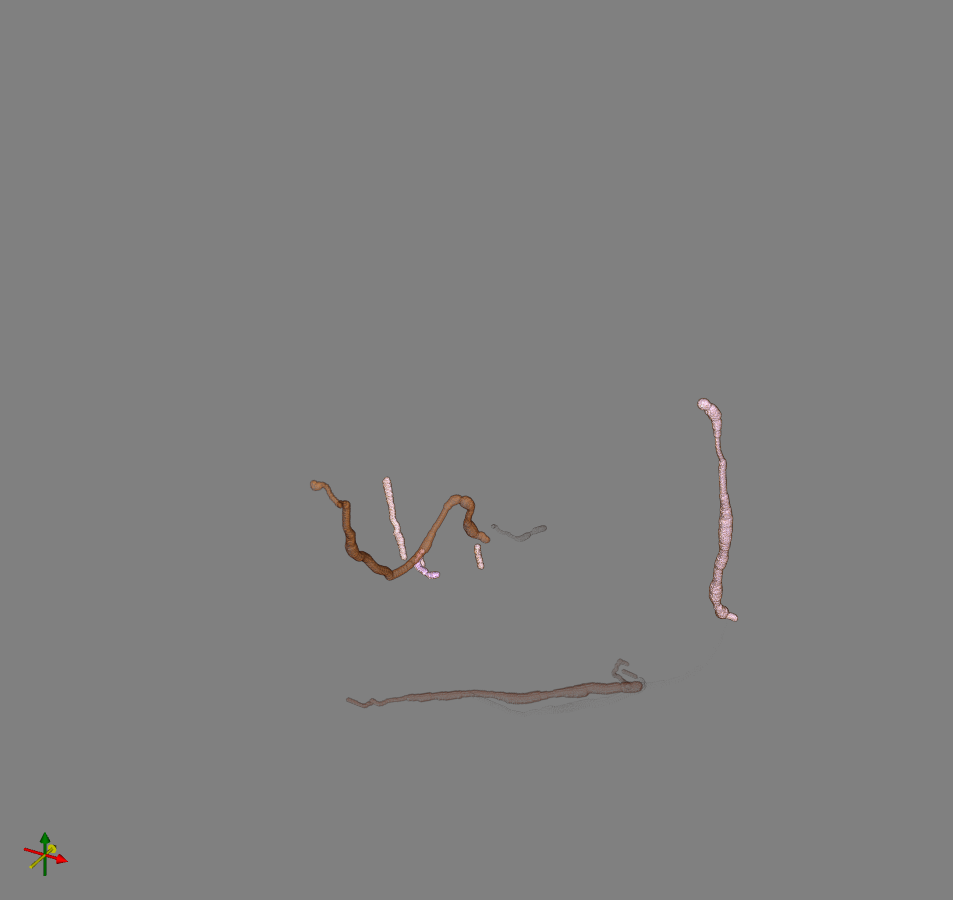
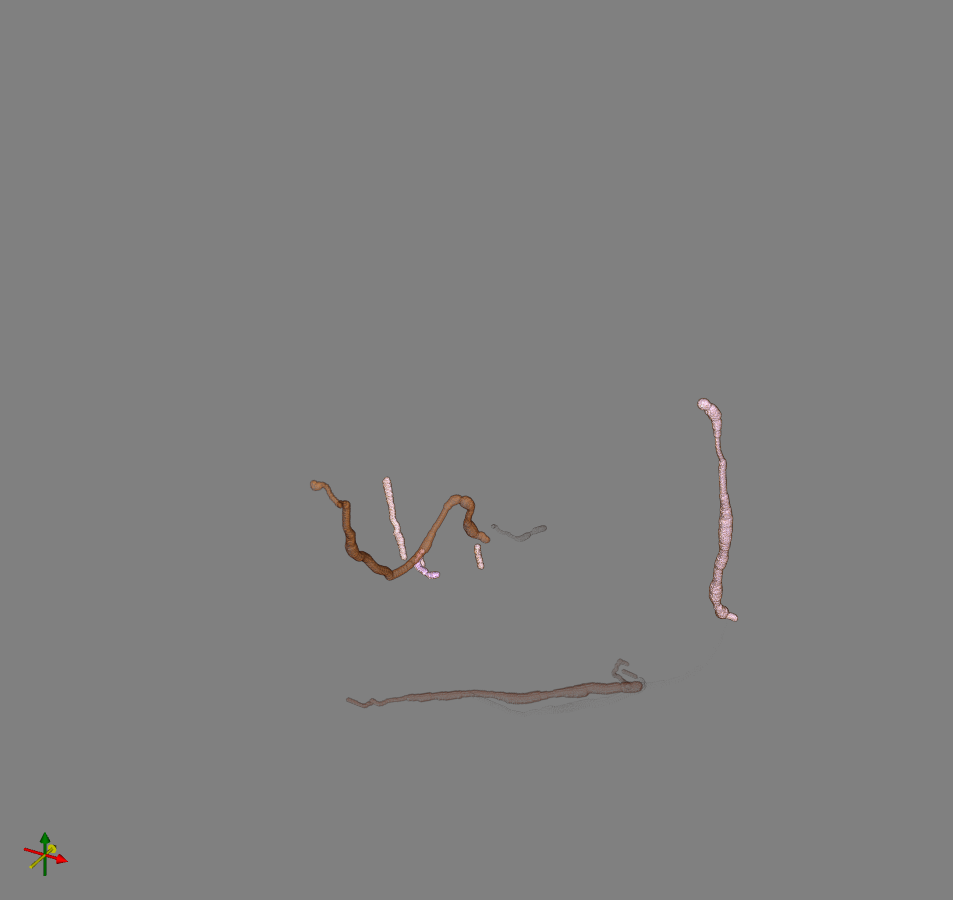

<IPython.core.display.Javascript object>

In [9]:
view(tubeMaskImage)

In [10]:
itk.imwrite(tubeMaskImage, OutputBaseName+"-VesselsInitial.mha")

In [11]:
ImageType = itk.Image[itk.F,3]
LabelMapType = itk.Image[itk.UC,3]

trMask = tube.ComputeTrainingMask[ImageType,LabelMapType].New()
trMask.SetInput( tubeMaskImage )
trMask.SetGap( 10 )
trMask.SetObjectWidth( 1 )
trMask.SetNotObjectWidth( 1 )
trMask.Update()
fgMask = trMask.GetOutput()

In [12]:
itk.imwrite(fgMask, OutputBaseName+"-VesselsInitialMask.mha")

In [13]:
enhancer = tube.EnhanceTubesUsingDiscriminantAnalysis[ImageType,LabelMapType].New()
enhancer.AddInput(imNorm)
enhancer.SetLabelMap(fgMask)
enhancer.SetRidgeId(255)
enhancer.SetBackgroundId(128)
enhancer.SetUnknownId(0)
enhancer.SetTrainClassifier(True)
enhancer.SetUseIntensityOnly(True)
enhancer.SetUseFeatureMath(True)
enhancer.SetScales([1*spacing, 2*spacing, 4*spacing])
enhancer.Update()
enhancer.ClassifyImages()

In [14]:
imMath.SetInput(enhancer.GetClassProbabilityImage(0))
imMath.Blur(0.5*spacing)
prob0 = imMath.GetOutput()
imMath.SetInput(enhancer.GetClassProbabilityImage(1))
imMath.Blur(0.5*spacing)
prob1 = imMath.GetOutput()

In [ ]:
itk.imwrite(prob0, OutputBaseName+"-Prob0.mha")
itk.imwrite(prob1, OutputBaseName+"-Prob1.mha")

In [ ]:
imDiff = itk.SubtractImageFilter(Input1=prob0, Input2=prob1)
imDiffArr = itk.GetArrayFromImage(imDiff)
dMax = imDiffArr.max()
imProbArr = imDiffArr / dMax
imVess = itk.GetImageFromArray(imProbArr)
imVess.CopyInformation(im)

In [ ]:
view(imVess)

<IPython.core.display.Javascript object>

In [ ]:
itk.imwrite( imVess, OutputBaseName+"-VesselsEnhanced.mha", compression=True)

In [ ]:
imMath = tube.ImageMath.New(imVess)
imMath.MedianFilter(1)
imMath.Threshold(0.000001, 1, 1, 0)
imVessMask = imMath.GetOutputShort()

ccSeg = tube.SegmentConnectedComponents.New(imVessMask)
ccSeg.SetMinimumVolume(100)
ccSeg.Update()
imVessMask = ccSeg.GetOutput()

itk.imwrite(imVessMask,OutputBaseName+"-VesselSeedsInitialMask.mha")
imVessMask = itk.imread(OutputBaseName+"-VesselSeedsInitialMask.mha", itk.F)

In [ ]:
imMath.SetInput(imVess)
imMath.ReplaceValuesOutsideMaskRange(imVessMask,2,99999,0)
imSeeds = imMath.GetOutput()
itk.imwrite(imSeeds,OutputBaseName+"-VesselSeeds.mha")

In [ ]:
imMath.SetInput(imVessMask)
imMath.Threshold(0,1,1,0)
imVessMaskInv = imMath.GetOutput()

distFilter = itk.DanielssonDistanceMapImageFilter.New(imVessMaskInv)
distFilter.Update()
dist = distFilter.GetOutput()

imMath.SetInput(dist)
imMath.Blur(0.4)
tmp = imMath.GetOutput()
imMath.ReplaceValuesOutsideMaskRange(tmp, 0.1, 10, 0)
imSeedsRadius = imMath.GetOutput()

itk.imwrite(imSeedsRadius, OutputBaseName+"-VesselSeedsRadius.mha")

In [ ]:
imMath.SetInput(imNorm)
imMath.ReplaceValuesOutsideMaskRange(imVessMask, 2, 99999, 0)
imMath.Blur(spacing)
imInput = imMath.GetOutput()

itk.imwrite(imInput,OutputBaseName+"-VesselInput.mha")

In [26]:
numSeeds = 1000

vSeg = tube.SegmentTubes.New(Input=imInput)
#vSeg.SetVerbose(True)
vSeg.SetMinCurvature(0.0001)
vSeg.SetMinRoundness(0.1)
vSeg.SetMinRidgeness(0.1)
vSeg.SetMinLevelness(0.001)
vSeg.SetMinLength(500) # old = 300
vSeg.SetRadiusInObjectSpace( spacing )
vSeg.SetBorderInIndexSpace(3)
vSeg.SetSeedMask( imSeeds )
vSeg.SetSeedRadiusMask( imSeedsRadius )
vSeg.SetOptimizeRadius(True)
vSeg.SetSeedMaskMaximumNumberOfPoints(numSeeds)
vSeg.SetUseSeedMaskAsProbabilities(True)
vSeg.SetSeedExtractionMinimumProbability(0.5) # old = 0.75
vSeg.ProcessSeeds()

In [27]:
tubeMaskImage = vSeg.GetTubeMaskImage()
itk.imwrite(tubeMaskImage,OutputBaseName+"-Vessels"+str(numSeeds)+".mha")


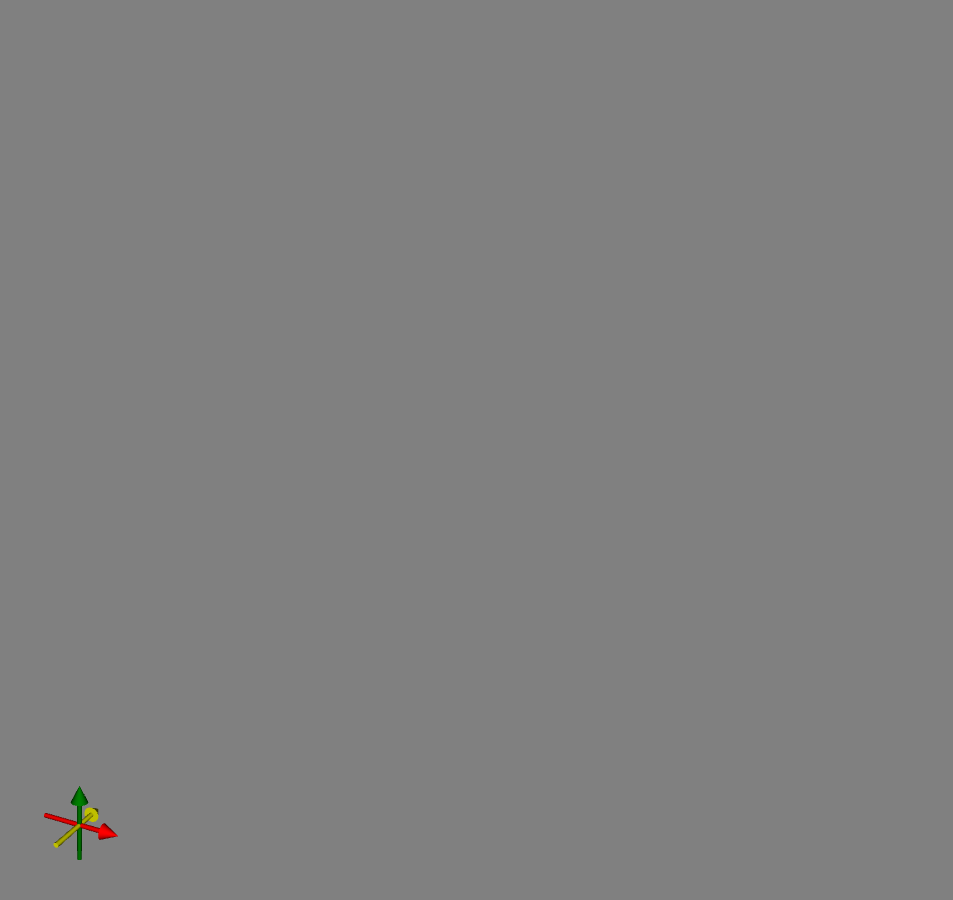
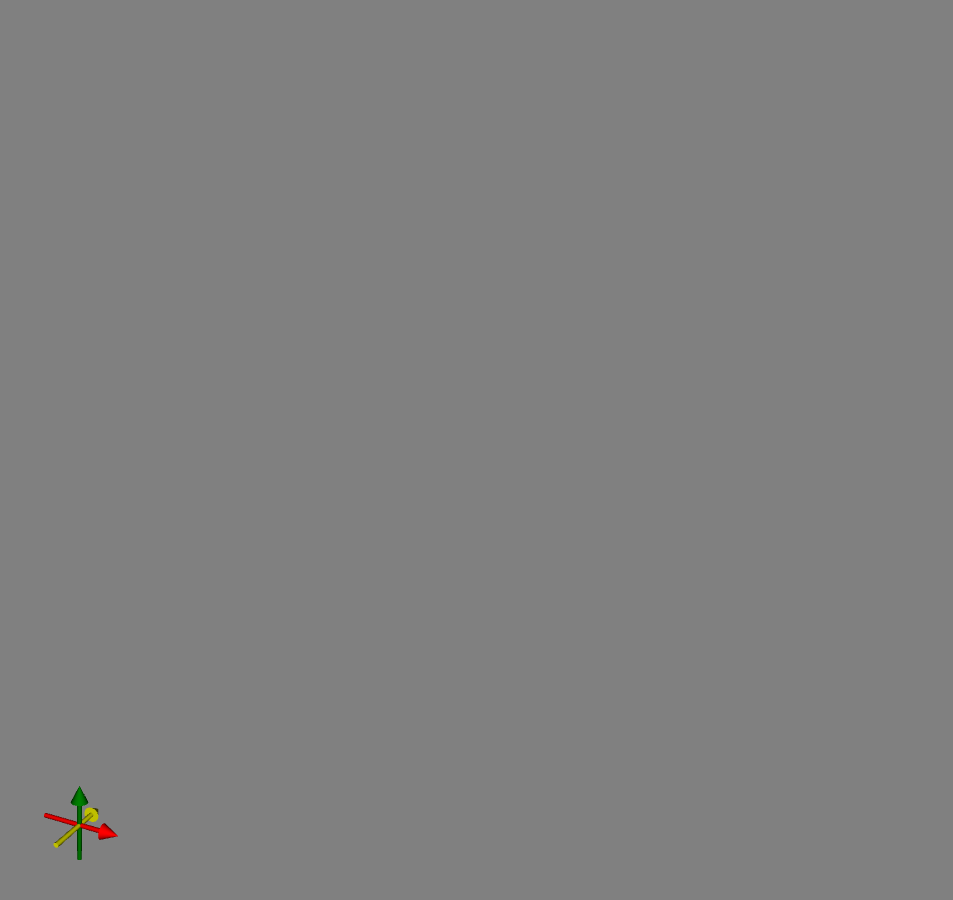

<IPython.core.display.Javascript object>

In [28]:
view(tubeMaskImage)

In [29]:
SOWriter = itk.SpatialObjectWriter[3].New()
SOWriter.SetInput(vSeg.GetTubeGroup())
SOWriter.SetBinaryPoints(True)
SOWriter.SetFileName(OutputBaseName+"-Vessels"+str(numSeeds)+".tre")
SOWriter.Update()

In [30]:
# smooth tubes!
TubeMath = tube.TubeMath[3, itk.F].New()
TubeMath.SetInputTubeGroup(vSeg.GetTubeGroup())
TubeMath.SetUseAllTubes()
TubeMath.SmoothTube(4,"SMOOTH_TUBE_USING_INDEX_GAUSSIAN")
TubeMath.SmoothTubeProperty("Radius",2,"SMOOTH_TUBE_USING_INDEX_GAUSSIAN")
tubes = TubeMath.GetOutputTubeGroup()

In [31]:
ConvSurface = tube.WriteTubesAsPolyData.New()
ConvSurface.SetInput(tubes)
ConvSurface.SetFileName(OutputBaseName+"-Vessels"+str(numSeeds)+".vtp")
ConvSurface.Update()